In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import pprint
from boto.s3.connection import S3Connection
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import pylab as pl
import numpy as np


%matplotlib inline

# Limit rows disp# Limit rows displayed in notebook
pd.set_option('display.max_rows', 20)
pd.set_option('display.precision', 2)

Getting business and review data

In [6]:
import json
import pandas
 
def convertBusiness(x):
    ob = json.loads(x)
    for k, v in ob.items():
        if isinstance(v, list):
            ob[k] = ','.join(v)
        elif isinstance(v, dict):
            for kk, vv in v.items():
                ob['%s_%s' % (k, kk)] = vv
            del ob[k]
    return ob

def convertReviews(x):
    ''' Convert a json string to a flat python dictionary
    which can be passed into Pandas. '''
    ob = json.loads(x)
    return {"business_id":ob["business_id"], "stars":ob["stars"], "date":ob["date"]}

def createPandas(func, json_filename):
    return pd.DataFrame([func(line) for line in file(json_filename)])

print "Creating Business Pandas"
pd_business = createPandas(convertBusiness,'yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_business.json')
print "Creating Review Pandas"
pd_review = createPandas(convertReviews, 'yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_review.json')
print "Completed Creating Pandas"

Creating Business Pandas
Creating Review Pandas
Completed Creating Pandas


Getting business and review data in Vegas

In [7]:
pd_business_lasvegas = pd_business[pd_business["city"] == "Las Vegas"]
pd_review_lasvegas = pd.merge(pd_business_lasvegas, pd_review, left_on='business_id', right_on='business_id', how='inner')

Geographic Clustering of Data

In [11]:
''' DBSCAN : Okayish results '''

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import pylab as pl
import numpy as np

business_lasvegas_latlong = pd_business_lasvegas[["latitude", "longitude"]].values.tolist()
X = StandardScaler().fit_transform(business_lasvegas_latlong)
db = DBSCAN(eps=0.2, min_samples=10).fit(X)
core_samples = db.core_sample_indices_
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)
colors = pl.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'k'
        markersize = 6
    class_members = [index[0] for index in np.argwhere(labels == k)]
    cluster_core_samples = [index for index in core_samples
                            if labels[index] == k]
    
    for index in class_members:
        x = X[index]
        if index in core_samples and k != -1:
            markersize = 14
        else:
            markersize = 6
        pl.plot(x[0], x[1], 'o', markerfacecolor=col,
                markeredgecolor='k', markersize=markersize)

ImportError: No module named dbscan

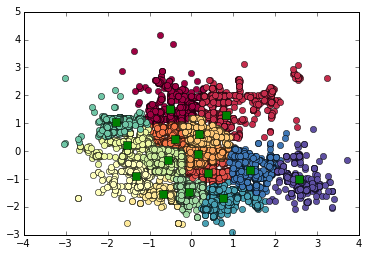

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
''' K Means with results '''

from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
from scipy.cluster.vq import kmeans,kmeans2, vq

business_lasvegas_latlong = pd_business_lasvegas[["latitude", "longitude"]].values.tolist()
X = StandardScaler().fit_transform(business_lasvegas_latlong)

k = 15
centroids, labels = kmeans2(X,k)
idx,_ = vq(X,centroids)
colors = pl.cm.Spectral(np.linspace(0, 1, k))
for i in range(k):
    plot(X[idx==i,0],X[idx==i,1], 'o', markerfacecolor=colors[i])
plot(centroids[:,0],centroids[:,1],'sg',markersize=8)
show()

# Adding column Cluster indicating cluser number
pd_business_lasvegas['cluster'] = pd.Series(labels, index=pd_business_lasvegas.index)

Label new and old businesses in the cluster

In [9]:
import cPickle as pickle

pd_review_lasvegas = pd.merge(pd_business_lasvegas, pd_review, left_on='business_id', right_on='business_id', how='inner')
gb = pd_review_lasvegas.groupby(['business_id'])
gb = gb.agg({'date' : np.min})
gb["new"] = (gb["date"] >= "2011-01-01")
pd_review_lasvegas = pd_review_lasvegas.set_index('business_id')
pd_lasvegas = pd.merge(pd_review_lasvegas, gb, left_index=True, right_index=True, how='inner')
pickle.dump( pd_lasvegas, open( "pd_lasvegas_15.pkl", "wb" ) )


#import cPickle as pickle
#pd_lasvegas = pickle.load(open("pd_lasvegas.pkl", "rb"))

In [26]:
#pd_lasvegas = pd_lasvegas.reset_index()

pd_lasvegas = pd_lasvegas[["business_id", "stars_y", "date_x", "new"]][pd["cluster"]==0]
pd_new = pd_lasvegas[pd_lasvegas["new"] == True]
pd_old = pd_lasvegas[pd_lasvegas["new"] == False]


import pandas as pd
from datetime import date, datetime, time, timedelta

for i in range(len(pd_new)):
    
    new_bizid =  pd_new.iloc[i]["business_id"]
    start_date =  pd_new.iloc[i]["date_x"]
    end_date = pd.to_datetime(start_date) + timedelta(days = 100)
    print pd_new
    '''
    pd_new_range = pd_new[pd_new["business_id"] == new_bizid][pd_new["date_y"]< end_date]
    print pd_new_range[["business_id", "date_y"]]
    break
    '''

                   business_id  stars_y      date_x   new
0       --1emggGHgoG6ipd_RMb-g        5  2013-03-30  True
1       --1emggGHgoG6ipd_RMb-g        5  2013-06-21  True
2       --1emggGHgoG6ipd_RMb-g        1  2013-10-02  True
3       --1emggGHgoG6ipd_RMb-g        4  2014-06-13  True
11      --jFTZmywe7StuZ2hEjxyA        4  2012-10-24  True
12      --jFTZmywe7StuZ2hEjxyA        4  2012-12-12  True
13      --jFTZmywe7StuZ2hEjxyA        5  2014-02-11  True
14      --jFTZmywe7StuZ2hEjxyA        2  2014-08-11  True
227     -0VK5Z1BfUHUYq4PoBYNLw        4  2013-11-08  True
228     -0VK5Z1BfUHUYq4PoBYNLw        3  2014-02-04  True
229     -0VK5Z1BfUHUYq4PoBYNLw        4  2014-09-26  True
230     -0VK5Z1BfUHUYq4PoBYNLw        4  2014-10-24  True
231     -0lRv242OzyPUB8c5E_UhQ        4  2011-06-07  True
232     -0lRv242OzyPUB8c5E_UhQ        4  2011-08-14  True
233     -0lRv242OzyPUB8c5E_UhQ        5  2011-08-22  True
234     -0lRv242OzyPUB8c5E_UhQ        4  2011-10-11  True
235     -0lRv2

KeyboardInterrupt: 

In [1]:


attrs = [u'attributes_Accepts Credit Cards', u'attributes_Accepts Insurance',
       u'attributes_Ages Allowed', u'attributes_Alcohol',
       u'attributes_Ambience', u'attributes_Attire', u'attributes_BYOB',
       u'attributes_BYOB/Corkage', u'attributes_By Appointment Only',
       u'attributes_Caters', u'attributes_Coat Check',
       u'attributes_Corkage', u'attributes_Delivery',
       u'attributes_Dietary Restrictions', u'attributes_Dogs Allowed',
       u'attributes_Drive-Thru', u'attributes_Good For',
       u'attributes_Good For Dancing', u'attributes_Good For Groups',
       u'attributes_Good For Kids', u'attributes_Good for Kids',
       u'attributes_Hair Types Specialized In', u'attributes_Happy Hour',
       u'attributes_Has TV', u'attributes_Music',
       u'attributes_Noise Level', u'attributes_Open 24 Hours',
       u'attributes_Order at Counter', u'attributes_Outdoor Seating',
       u'attributes_Parking', u'attributes_Payment Types',
       u'attributes_Price Range', u'attributes_Smoking',
       u'attributes_Take-out', u'attributes_Takes Reservations',
       u'attributes_Waiter Service', u'attributes_Wheelchair Accessible',
       u'attributes_Wi-Fi', u'categories', u'city', u'full_address',
       u'hours_Friday', u'hours_Monday', u'hours_Saturday',
       u'hours_Sunday', u'hours_Thursday', u'hours_Tuesday',
       u'hours_Wednesday',u'neighborhoods', u'open']

def getVector(old, new):
    res = []
    for attr in attrs:
        if pd.isnull(old[attr]) or pd.isnull(new[attr]):
            continue
        res.append({attr: old[attr] == new[attr]})
    return res

pd_lasvegas_cluster = pd_lasvegas[pd_lasvegas["cluster"] == 0] 
pd_lasvegas_new = pd_lasvegas_cluster[pd_lasvegas_cluster["new"] == True]
pd_lasvegas_old = pd_lasvegas_cluster[pd_lasvegas_cluster["new"] == False]
    

temp_lasvegas_new = pd_lasvegas_new[attrs]
temp_lasvegas_old = pd_lasvegas_old[attrs]

lasvegas_new_dict =  pd_lasvegas_new[attrs].T.to_dict()
lasvegas_old_dict =  temp_lasvegas_old.T.to_dict()

for new_business_id, new_val in lasvegas_new_dict.iteritems():
    business_vectors = []
    for old_business_id, old_val in lasvegas_old_dict.iteritems():
        business_vectors.append({old_business_id: getVector(old_val, new_val)})


NameError: name 'pd_lasvegas' is not defined

In [80]:
temp = pd_review_lasvegas.loc[[new_business_id]]
before_date = temp[["date"]].min()

before_review_lasvegas = pd_review_lasvegas[np.less(pd_review_lasvegas["date"] , before_date)]
before_review_lasvegas = before_review_lasvegas[["date", "stars_y"]]
#print before_review_lasvegas

after_review_lasvegas = pd_review_lasvegas[np.greater(pd_review_lasvegas["date"] , before_date)]
after_review_lasvegas = after_review_lasvegas[["date", "stars_y"]]

could_not_find, Y = 0, []
for idx, business_vector in enumerate(business_vectors):
    business_id = business_vector.keys()
    before_review =  before_review_lasvegas.loc[business_id]
    
    try:
        after_review = after_review_lasvegas.loc[business_id]
        
    except KeyError:
        could_not_find+=1
        Y.append(0.0)
        continue
    
    before_created = float(before_review[["stars_y"]].mean())
    after_created = float(after_review[["stars_y"]].mean())
    
    result = after_created - before_created
    Y.append(result)

Performing PCA to get Most Significant Attributes

In [82]:
from sklearn import decomposition



X = []
for new_business_id, new in lasvegas_new_dict.iteritems():
    count= 0
    for old_business_id, old in lasvegas_old_dict.iteritems():
        res = []
        for attr in attrs:
            #print attr, old[attr]
            if pd.isnull(old[attr]) or pd.isnull(new[attr]):
                res.append(0.0)
            elif old[attr] == new[attr]:
                res.append(1.0)
            else:
                res.append(0.0)
                
        res = np.array(res)
        X.append(res)
    break
    
X = np.array(X)
Y = np.array(Y)

In [83]:
print X[:1],X.shape
print Y[:1],Y.shape

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  1.]] (585, 45)
[ 0.] (585,)


Linear Regression

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


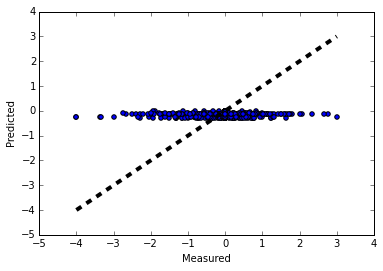

In [88]:
from sklearn.cross_validation import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt

lr = linear_model.LinearRegression()
predicted = cross_val_predict(lr, X, Y, cv=10)

fig, ax = plt.subplots()
ax.scatter(Y, predicted)
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

PCA and Linear Regression

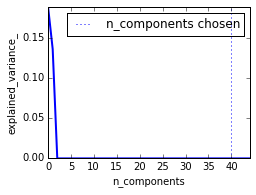

In [92]:
linear = linear_model.LinearRegression()

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('linear', linear)])

###############################################################################
# Plot the PCA spectrum
pca.fit(X)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

###############################################################################
# Prediction

n_components = [20, 40]
Cs = np.logspace(-4, 4)

#Parameters of pipelines can be set using ‘__’ separated parameter names:

estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components))
estimator.fit(X, Y)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()